<h1 style="color:#ff69b4"> Metrics Evaluation </h1>

### Imports

In [78]:
#! pip install 
#pip install lpips


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torch
import os
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.models import inception_v3
from torchvision.utils import save_image
from PIL import Image
#import metrics
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from sklearn.metrics import mean_absolute_error
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips




### Img selection 


In [ ]:
def load_nifti_slice(path, slice_idx=60):
    img = nib.load(path)
    data = img.get_fdata()
    #slice_2d = data[:, :, slice_idx] # Select a specific slice
    slice_2d =  data.shape[2] // 2# Select the middle slice
    slice_2d = np.rot90(slice_2d)  # Rotate the slice for correct orientation
    return slice_2d / np.max(slice_2d)  # Normalize to [0, 1]

#using one subject for testing
img_3T = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/3T/sub-MS3T004_T1w_MNI152_ANTs.nii.gz')
img_7T_real = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/7T/sub-MS7T004_T1w_MNI152_ANTs.nii.gz')
img_7T_synth = load_nifti_slice('/home/nbelloula/GAI/Synthetic7TMRI/data/original/7T_synthetic/sub-MS3T004_T1w_MNI152_ANTs_pred.nii.gz')

#check the shape of the images
print(f"3T Image Shape: {img_3T.shape}")
print(f"7T Real Image Shape: {img_7T_real.shape}")
print(f"7T Synth Image Shape: {img_7T_synth.shape}")
# Display the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_3T, cmap='gray')
plt.title('3T Image')
plt.subplot(1, 3, 2)
plt.imshow(img_7T_real, cmap='gray')
plt.title('7T Real Image')
plt.subplot(1, 3, 3)
plt.imshow(img_7T_synth, cmap='gray')
plt.title('7T Synth Image')
plt.show()



ValueError: Axes=(0, 1) out of range for array of ndim=0.

### Compute metrics zw 2 images

In [32]:
#compute metric separately for each image
def compute_ssim(img1, img2):
    return SSIM(img1, img2)
def compute_psnr(img1, img2):
    return PSNR(img1, img2)
def compute_mae(img1, img2):
    return mean_absolute_error(img1.flatten(), img2.flatten())
def compute_lpips(img1, img2):
    img1_tensor = torch.tensor(img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    img2_tensor = torch.tensor(img2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    loss_fn = lpips.LPIPS(net='alex')  # net='alex' or 'vgg'
    return loss_fn(img1_tensor, img2_tensor).item()
def compute_FID(img1, img2):
    fid = FrechetInceptionDistance(feature=64)
    fid.update(img1, real=True)
    fid.update(img2, real=False)
    fid_score = fid.compute()
    return fid_score

In [34]:
def compute_mae(img1, img2):
    return mean_absolute_error(img1.flatten(), img2.flatten())


In [41]:
def compute_ssim(img1, img2):
    ssim = SSIM(img1, img2, data_range=1.0)
    #format ssim to be between 0 and 1
    ssim = (ssim + 1) / 2  # Adjusting SSIM to be in the range [0, 1]
    return ssim


In [ ]:
def compute_psnr(img1, img2):
    return PSNR(img1, img2, data_range=1.0)

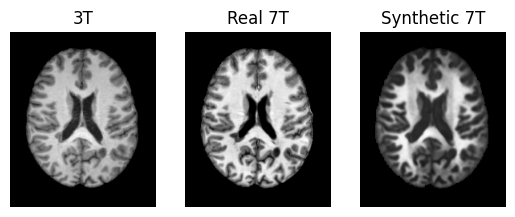

In [45]:
fig, axs = plt.subplots(1, 3)
titles = ['3T', 'Real 7T', 'Synthetic 7T']
for ax, img, title in zip(axs, [img_3T, img_7T_real, img_7T_synth], titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [77]:
#display images and metrics
# Compute metrics    
mae_3Tself = compute_mae(img_3T, img_3T)
mae_value37r = mean_absolute_error(img_3T, img_7T_real)
mae_values37s = mean_absolute_error(img_3T, img_7T_synth)
mae_values7r7s = mean_absolute_error(img_7T_real, img_7T_synth)

print(f"MAE (3T vs 3T): {mae_3Tself:.4f}")
print(f"MAE (3T vs real 7T): {mae_value37r:.4f}")
print(f"MAE (3T vs synthetic 7T): {mae_values37s:.4f}")
print(f"MAE (real 7T vs synthetic 7T): {mae_values7r7s:.4f}")

#  #display images and metrics
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# axs[0].imshow(img_3T, cmap='gray')
# axs[0].set_title('3T Image')
# axs[1].imshow(img_7T_real, cmap='gray')
# axs[1].set_title('7T Real Image')
# axs[2].imshow(img_7T_synth, cmap='gray')
# axs[2].set_title('7T Synth Image')

# plt.tight_layout()
# plt.show() 

MAE (3T vs 3T): 0.0000
MAE (3T vs real 7T): 0.0564
MAE (3T vs synthetic 7T): 0.0740
MAE (real 7T vs synthetic 7T): 0.0965


In [ ]:
ssim_value3Tself = compute_ssim(img_3T, img_3T)
ssim_value37r = compute_ssim(img_3T, img_7T_real)
ssim_values37s = compute_ssim(img_3T, img_7T_synth)
ssim_values7r7s = compute_ssim(img_7T_real, img_7T_synth)

print(f"SSIM (3T vs 3T): {ssim_value3Tself:.4f}")   
print(f"SSIM (3T vs real 7T): {ssim_value37r:.4f}")
print(f"SSIM (3T vs synthetic 7T): {ssim_values37s:.4f}")
print(f"SSIM (real 7T vs synthetic 7T): {ssim_values7r7s:.4f}")


SSIM (3T vs 3T): 1.0000
SSIM (3T vs real 7T): 0.9089
SSIM (3T vs synthetic 7T): 0.9174
SSIM (real 7T vs synthetic 7T): 0.8758


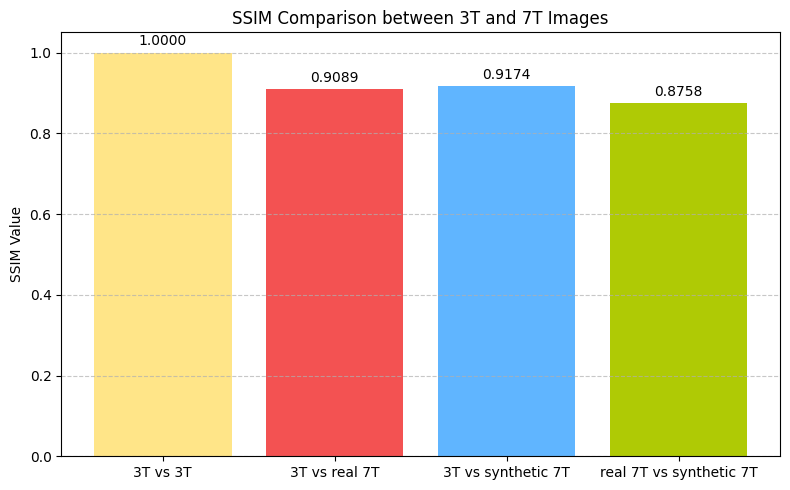

In [82]:
# Plotting the SSIM values in a bar chart
# SSIM values
ssim_values = [ssim_value3Tself, ssim_value37r, ssim_values37s, ssim_values7r7s]

# Labels for the comparisons
labels = [
    '3T vs 3T',
    '3T vs real 7T',
    '3T vs synthetic 7T',
    'real 7T vs synthetic 7T'
]

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ssim_values, color=['#ffe588', '#f35252', '#60b5ff', '#afca05'])

# Annotate bars with SSIM values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

# Customize chart
plt.ylabel('SSIM Value')
plt.ylim(0, 1.05)
plt.title('SSIM Comparison between 3T and 7T Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [85]:
psnr_value3Tself = compute_psnr(img_3T, img_3T)
psnr_value37r = compute_psnr(img_3T, img_7T_real)
psnr_values37s = compute_psnr(img_3T, img_7T_synth)
psnr_values7r7s = compute_psnr(img_7T_real, img_7T_synth)

print(f"PSNR (3T vs 3T): {psnr_value3Tself:.4f} dB")
print(f"PSNR (3T vs real 7T): {psnr_value37r:.4f} dB")
print(f"PSNR (3T vs synthetic 7T): {psnr_values37s:.4f} dB")
print(f"PSNR (real 7T vs synthetic 7T): {psnr_values7r7s:.4f} dB")

PSNR (3T vs 3T): inf dB
PSNR (3T vs real 7T): 20.1690 dB
PSNR (3T vs synthetic 7T): 18.2901 dB
PSNR (real 7T vs synthetic 7T): 15.6618 dB


/home/nbelloula/GAI/.venv/lib/python3.12/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


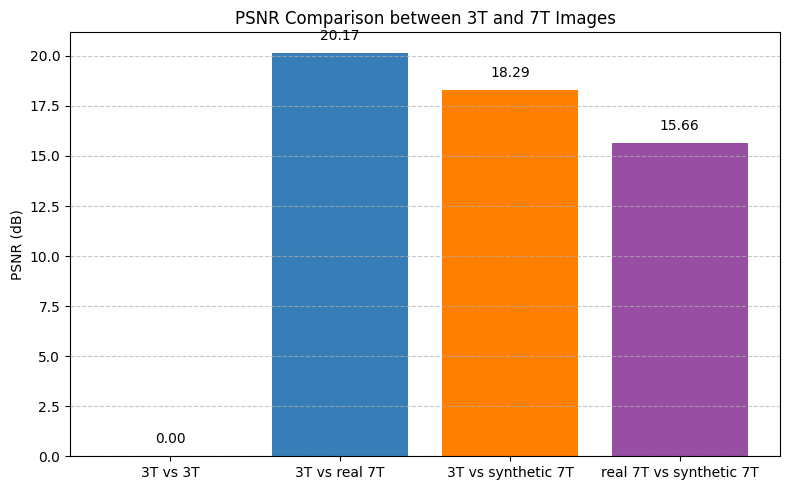

In [94]:
# Values and labels

#transform the inf value to symbole in the bar chart make it infinity

psnr_value3Tself = psnr_value3Tself if psnr_value3Tself != float('inf') else '∞'
psnr_values = [
    psnr_value3Tself,
    psnr_value37r,
    psnr_values37s,
    psnr_values7r7s
]

labels = [
    '3T vs 3T',
    '3T vs real 7T',
    '3T vs synthetic 7T',
    'real 7T vs synthetic 7T'
]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, psnr_values, color=['#4daf4a', '#377eb8', '#ff7f00', '#984ea3'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}', ha='center', va='bottom')

# Customize chart
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparison between 3T and 7T Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
lpips_model = lpips.LPIPS(net='alex', pretrained=True)  # Load the LPIPS model with AlexNet backbone
lpips_model.eval() # important to set the model to evaluation mode because LPIPS uses batch normalization and dropout layers which behave differently during training and evaluation
# Expected input shape for LPIPS is (N, C, H, W) 
# Convert images to 3-channel format for LPIPS
new_shape = (img_3T.shape[0], img_3T.shape[1], 1)  # Assuming img_3T is a 2D image
img_3T = img_3T.reshape(new_shape)
print(f"3T Image Reshaped: {img_3T.shape}")

# # load image not as a single channel but as a 3-channel image for lpips 
# # img_3Tvol = np.stack([img_3T]*3, axis=-1)  # Convert to 3-channel image
# # img_7T_synthvol = np.stack([img_7T_synth]*3, axis=-1)  # Convert to 3-channel image

# img_3T_LPIPS = np.repeat(img_3T[:, :, np.newaxis], 3, axis=2)

# #print shape of the image
# imgshape= img_3T_LPIPS.shape
# print

# img_7T_synth_LPIPS = np.repeat(img_7T_synth[:, :, np.newaxis], 3, axis=2)

# print(f"Image Shape: {img_3T_LPIPS.shape}") 


# def to_tensor(img):
#     transform = T.Compose([
#         T.ToPILImage(),
#         #T.Resize((256, 256)), 
#         T.ToTensor(),
#         T.Normalize([0.5], [0.5])
#     ])
#     return transform(np.stack([img]*3)).unsqueeze(0)

# img_3T_tensor = to_tensor(img_3T_LPIPS)
# img_7T_tensor = to_tensor(img_7T_synth_LPIPS)


# lpips_score = lpips_model(img_3T_tensor, img_7T_tensor).item()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nbelloula/GAI/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
3T Image Reshaped: (218, 182, 1)
